In [ ]:
# En caso que de ejecutar esto en Colab, van a tener que instalar Scikit-Plot para poder ver la curva de Silhouette.
#!pip install scikit-plot

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import set_config

set_config(transform_output="pandas")

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)
N = np.random.randint(5, 15, size=1)[0]
n_samples = np.random.randint(100, 1000, size=N)

In [2]:
X, _ = make_blobs(
    n_samples=n_samples,
    n_features=9,
    cluster_std=2.5,
    random_state=RANDOM_STATE,
)
df = pd.DataFrame(X)
dict_cat = {
    0: "Cat 1",
    1: "Cat 2",
    2: "Cat 3",
}
rng = np.random.default_rng()
df["cat_var"] = rng.choice(a=[0, 1, 2], size=len(df), p=[0.2, 0.3, 0.5])
df["cat_var"] = df["cat_var"].map(dict_cat)

df.columns = [f"x{i}" for i, _ in enumerate(df.columns, start=1)]
df["x1"] += 100
df["x5"] *= 327
df["x9"] /= 15

df.to_csv("proyecto_clustering.csv", index=False)

> Las primeras celdas son sólo para poder generar el dataset de muestra. Esto generará un archivo llamado: `proyecto_clustering.csv`

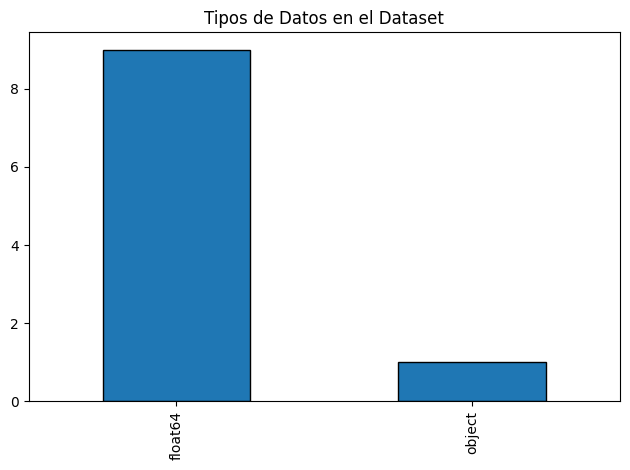

In [3]:
## Acá comienza oficialmente el código.
df = pd.read_csv("proyecto_clustering.csv")
df.dtypes.value_counts().plot(
    kind="bar", title="Tipos de Datos en el Dataset", edgecolor="k"
)
plt.tight_layout()

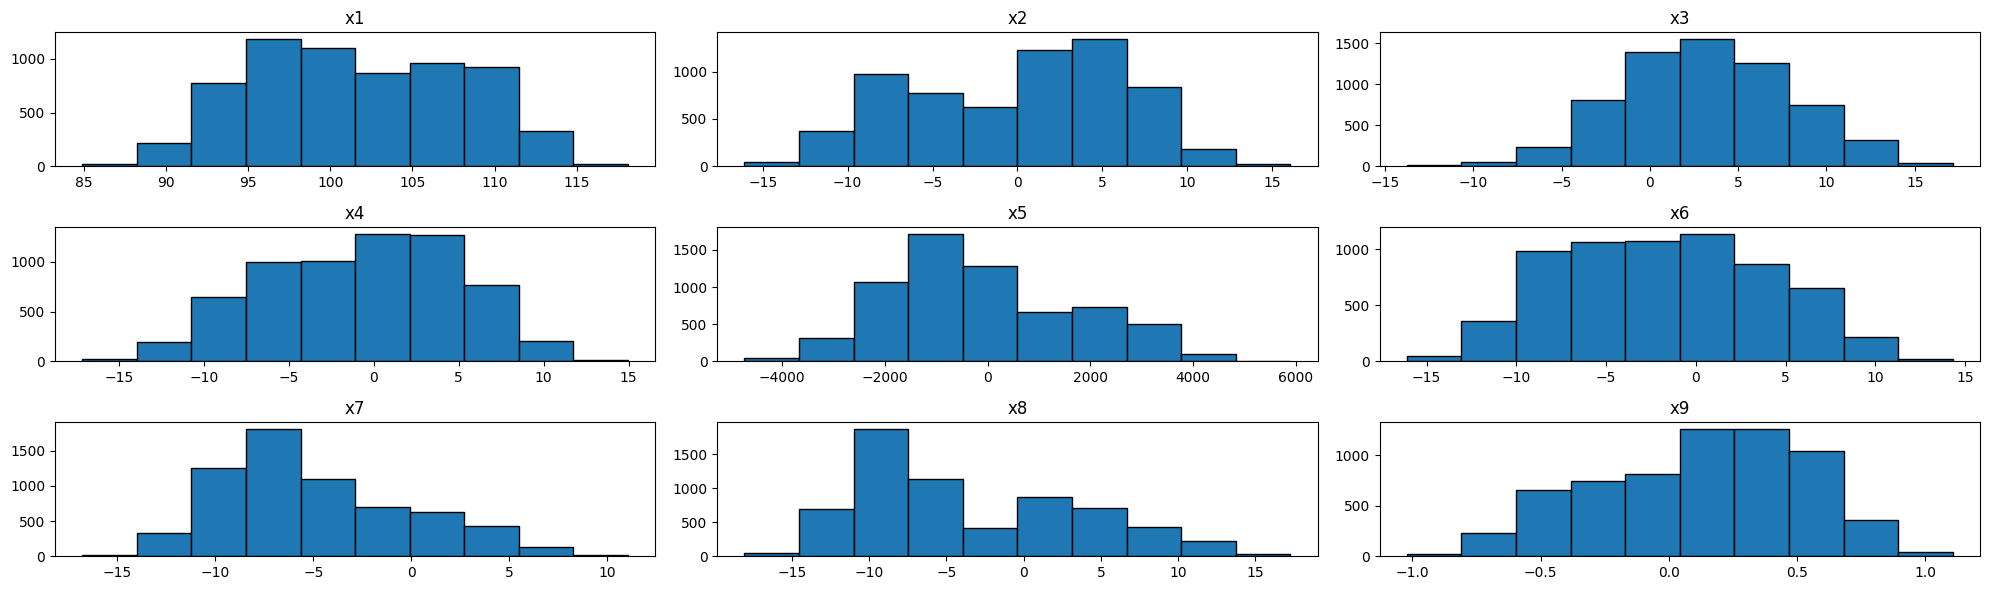

In [4]:
df.hist(figsize=(20, 6), edgecolor="k", grid=False)
plt.tight_layout()

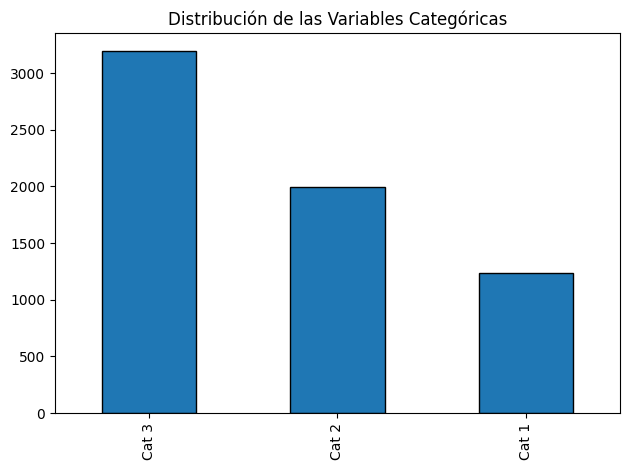

In [5]:
df["x10"].value_counts().plot(
    kind="bar",
    edgecolor="k",
    title="Distribución de las Variables Categóricas",
)
plt.tight_layout()

## Variables Categóricas


In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
dummy_vars = ohe.fit_transform(df[["x10"]])

X = pd.concat([df.drop(columns="x10"), dummy_vars], axis=1)
X

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10_Cat 1,x10_Cat 2,x10_Cat 3
0,105.576134,4.823419,3.409904,-11.687494,-1532.613468,-4.589218,-6.854641,-8.877022,-0.449964,0.0,0.0,1.0
1,100.479786,-4.876628,-5.404970,6.932649,-4092.341900,12.163845,-6.502116,10.874025,0.348683,0.0,0.0,1.0
2,97.357744,8.467431,-0.865210,4.353712,1444.577125,-1.992772,-12.223474,-9.100414,0.407230,0.0,0.0,1.0
3,95.857842,5.931475,0.278352,3.413013,1959.773064,-10.248761,-8.136656,-9.158037,0.478212,0.0,0.0,1.0
4,99.772427,-2.876912,4.499859,1.308382,-2318.502069,2.062409,-13.469304,-0.236395,0.478002,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6418,98.951606,6.649525,1.869195,1.765821,4348.322822,-6.866256,-1.578755,-12.749590,0.454056,0.0,0.0,1.0
6419,94.996949,-6.638457,3.999433,0.989885,-1811.824888,-0.859185,-7.422772,3.293839,0.558469,0.0,0.0,1.0
6420,95.495497,6.664764,0.019823,1.825686,2845.172238,-7.376139,-8.056029,-10.066078,0.224961,0.0,0.0,1.0
6421,99.435967,5.469512,6.342347,-1.182801,-358.410366,-1.205160,2.248149,6.840680,0.748647,0.0,1.0,0.0


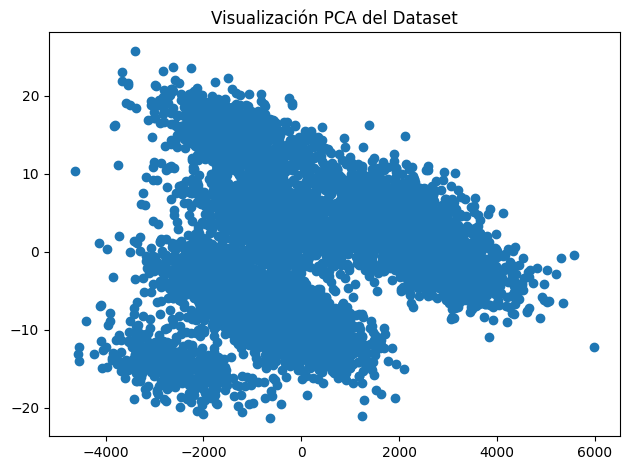

In [7]:
pca = PCA(n_components=2, random_state=42)
pca_X = pca.fit_transform(X)
plt.scatter(pca_X["pca0"], pca_X["pca1"])
plt.title("Visualización PCA del Dataset")
plt.tight_layout()

# Preparación de los Datos

In [8]:
num_vars = [f"x{i}" for i in range(1, 10)]
cat_vars = [col for col in X.columns if col not in num_vars]
cat_vars

['x10_Cat 1', 'x10_Cat 2', 'x10_Cat 3']

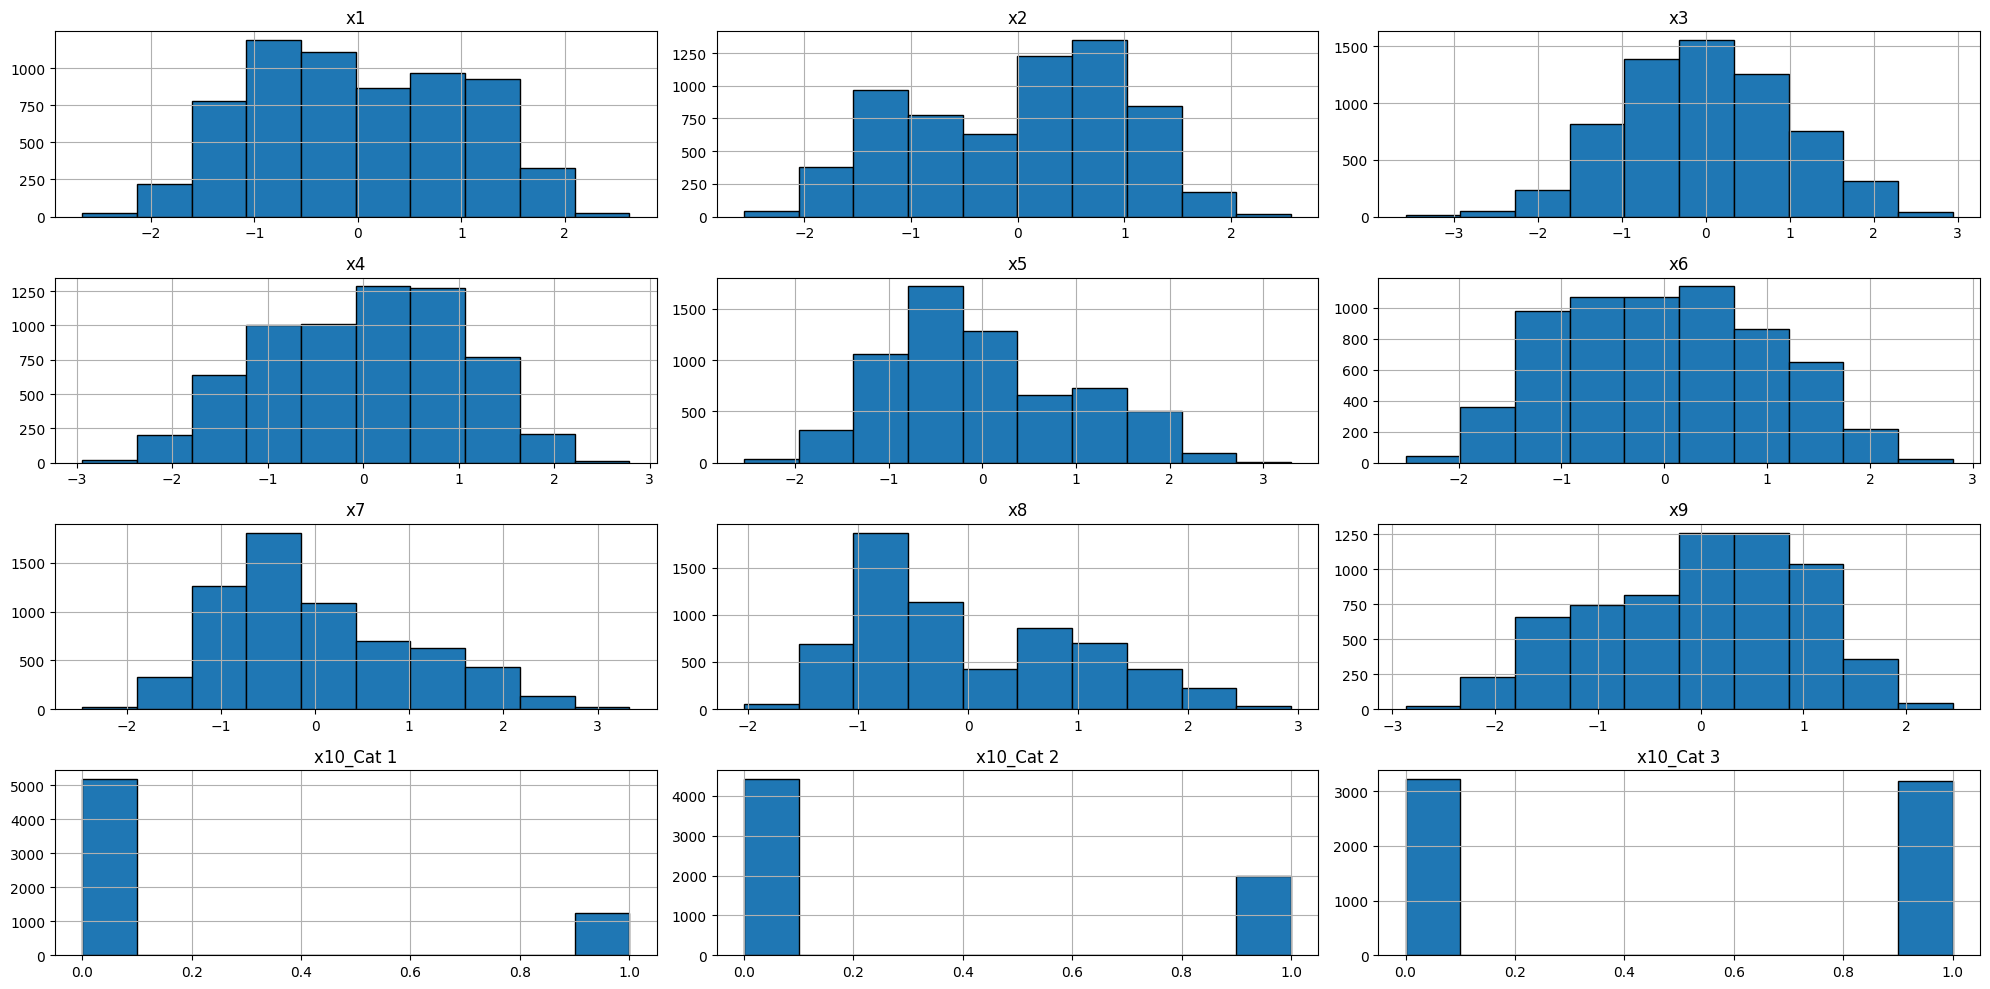

In [9]:
sc = StandardScaler()
X[num_vars] = sc.fit_transform(X[num_vars])
X.hist(figsize=(20, 10), edgecolor="k")
plt.tight_layout()

## K-Means

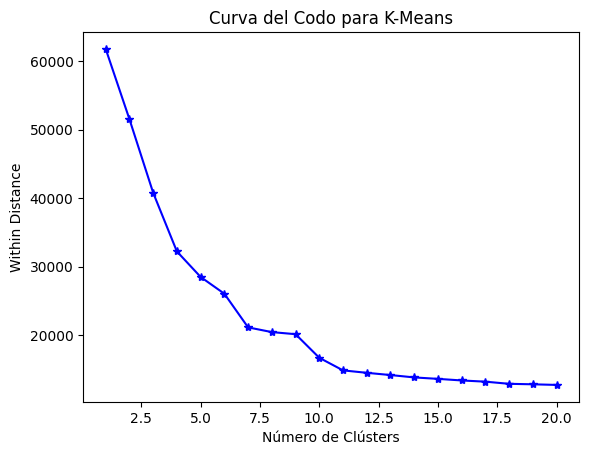

In [10]:
def elbow_curve(X, k_max=10, color="blue", title=None):
    wc = []
    for k in range(1, k_max + 1):
        km = KMeans(n_clusters=k, random_state=1)
        km.fit(X)
        wc.append(km.inertia_)

    k = [*range(1, k_max + 1)]
    plt.plot(k, wc, c=color, marker="*")
    plt.title(title)
    plt.xlabel("Número de Clústers")
    plt.ylabel("Within Distance")
    return wc


wc = elbow_curve(
    X, k_max=20, color="blue", title="Curva del Codo para K-Means"
)

In [11]:
metricas = dict()

In [12]:
K_KMEANS = 10
km = KMeans(n_clusters=K_KMEANS, n_init=10, random_state=RANDOM_STATE)
labels_km = km.fit_predict(X)

In [13]:
s_km = silhouette_score(X, labels_km)
metricas["km_10"] = s_km
metricas

{'km_10': 0.39419687509752793}

## Jerárquico

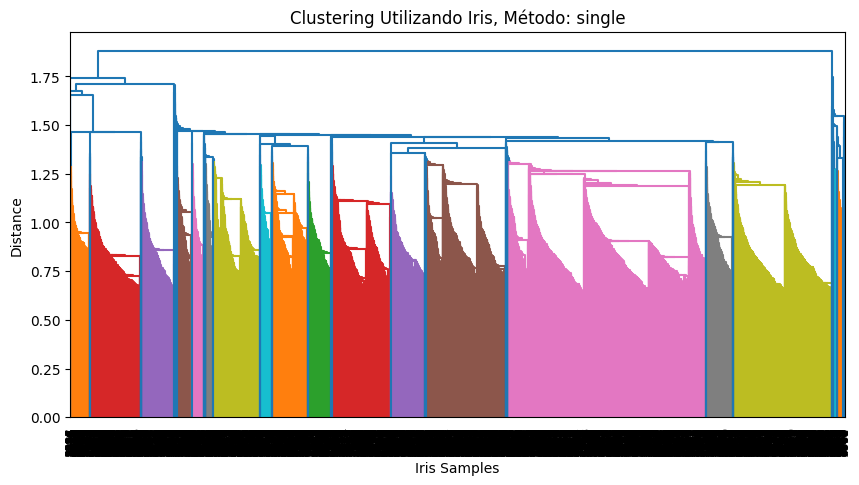

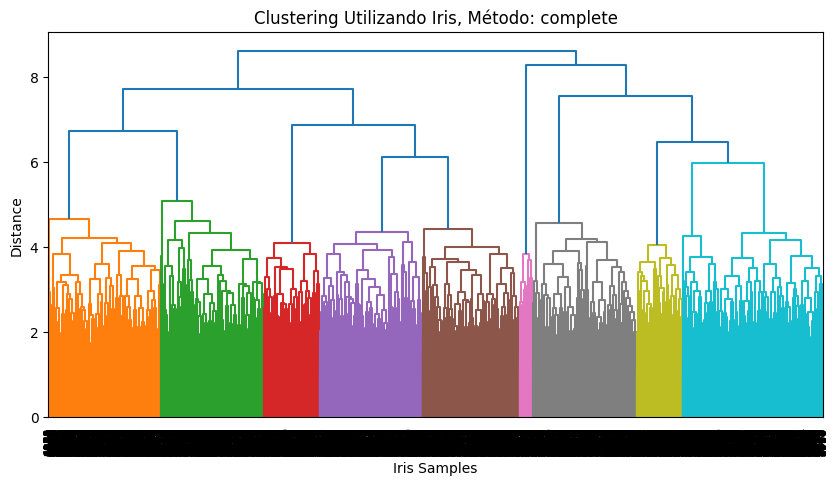

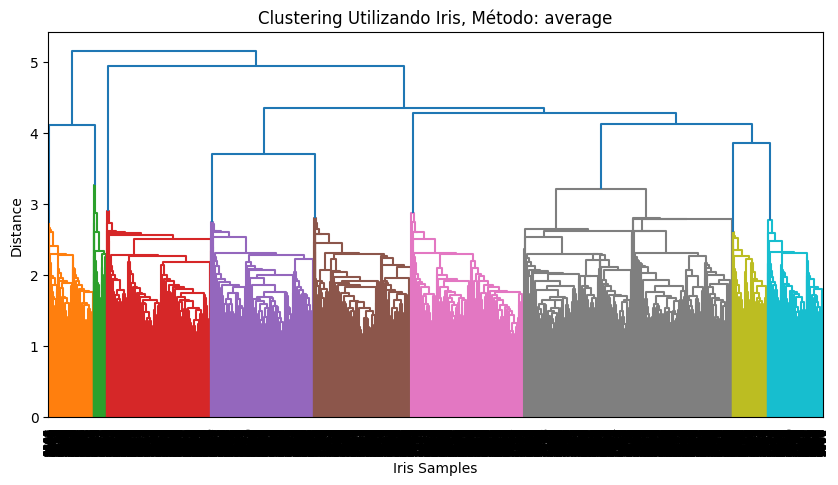

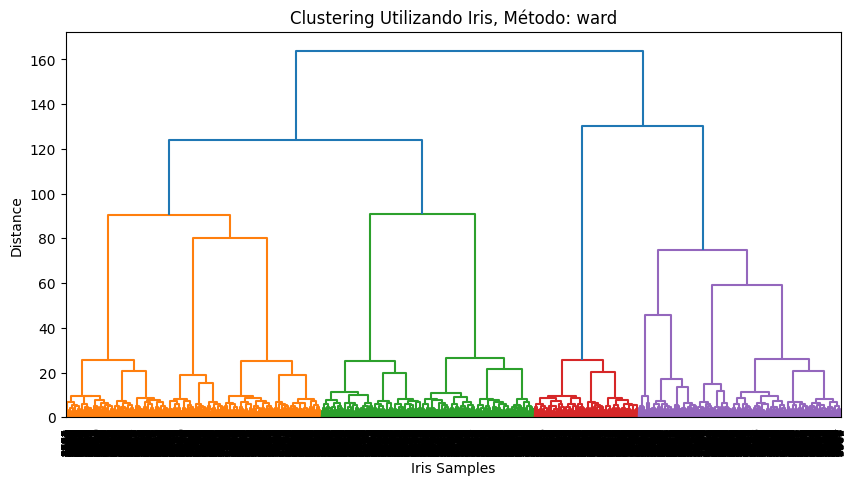

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage


def plot_dendogram(X, link="ward"):
    Z = linkage(X, method=link)

    plt.figure(figsize=(10, 5))
    plt.title(f"Clustering Utilizando Iris, Método: {link}")
    plt.xlabel("Iris Samples")
    plt.ylabel("Distance")
    dendrogram(Z, leaf_rotation=90.0, leaf_font_size=8.0)
    plt.show()


linkage_list = ["single", "complete", "average", "ward"]
for l in linkage_list:
    plot_dendogram(X, link=l)

In [15]:
def train_hierarchical(K_H, linkage):
    hc = AgglomerativeClustering(n_clusters=K_H, linkage=linkage)
    labels_h = hc.fit_predict(X)
    s_h = silhouette_score(X, labels_h)
    print(f"El coeficiente de Silueta es {s_h}")
    return labels_h, s_h


labels_c9, s_c9 = train_hierarchical(K_H=9, linkage="complete")
labels_a9, s_a9 = train_hierarchical(K_H=9, linkage="average")
labels_w4, s_w4 = train_hierarchical(K_H=4, linkage="ward")

El coeficiente de Silueta es 0.37657025597625804
El coeficiente de Silueta es 0.3812263959798965
El coeficiente de Silueta es 0.2852126845283154


In [16]:
metricas["s_c9"] = s_c9
metricas["s_a9"] = s_a9
metricas["s_w4"] = s_w4
metricas

{'km_10': 0.39419687509752793,
 's_c9': 0.37657025597625804,
 's_a9': 0.3812263959798965,
 's_w4': 0.2852126845283154}

## DBSCAN

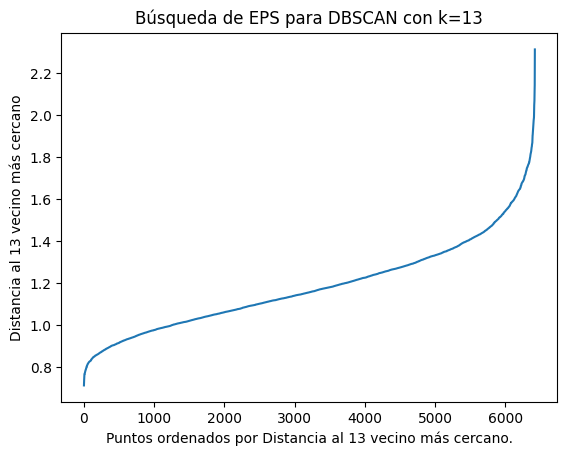

In [17]:
from sklearn.neighbors import NearestNeighbors

MIN_SAMPLES = X.shape[1] + 1


def dbscan_elbow_plot(X, k=5):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    distances, _ = knn.kneighbors(X)
    distances = np.sort(distances[:, -1])
    n_pts = distances.shape[0]

    plt.plot(range(1, n_pts + 1), distances)
    plt.xlabel(
        f"Puntos ordenados por Distancia al {k} vecino más cercano."
    )
    plt.ylabel(f"Distancia al {k} vecino más cercano")
    plt.title(f"Búsqueda de EPS para DBSCAN con k={k}")


dbscan_elbow_plot(X, k=MIN_SAMPLES)

EPS = 1.6

In [18]:
dbs = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
labels_dbs = dbs.fit_predict(X)
s_dbs = silhouette_score(X, labels_dbs)
metricas["s_dbs"] = s_dbs
metricas

{'km_10': 0.39419687509752793,
 's_c9': 0.37657025597625804,
 's_a9': 0.3812263959798965,
 's_w4': 0.2852126845283154,
 's_dbs': 0.1818560991479739}

## Evaluación

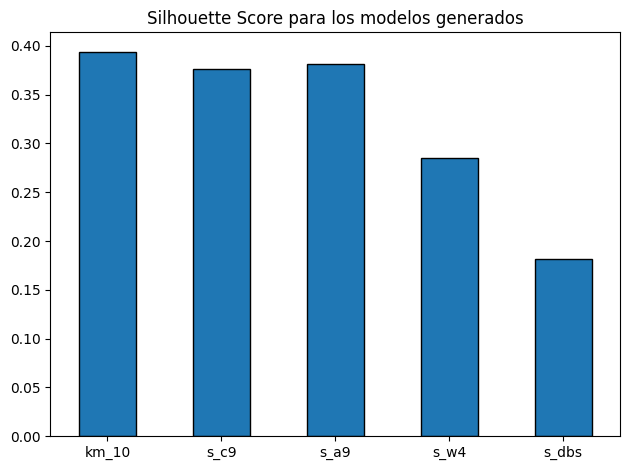

In [19]:
pd.Series(metricas.values(), index=metricas.keys()).plot(
    kind="bar",
    rot=0,
    edgecolor="k",
    title="Silhouette Score para los modelos generados",
)
plt.tight_layout()

In [20]:
labels_km

array([5, 9, 2, ..., 2, 0, 1], dtype=int32)

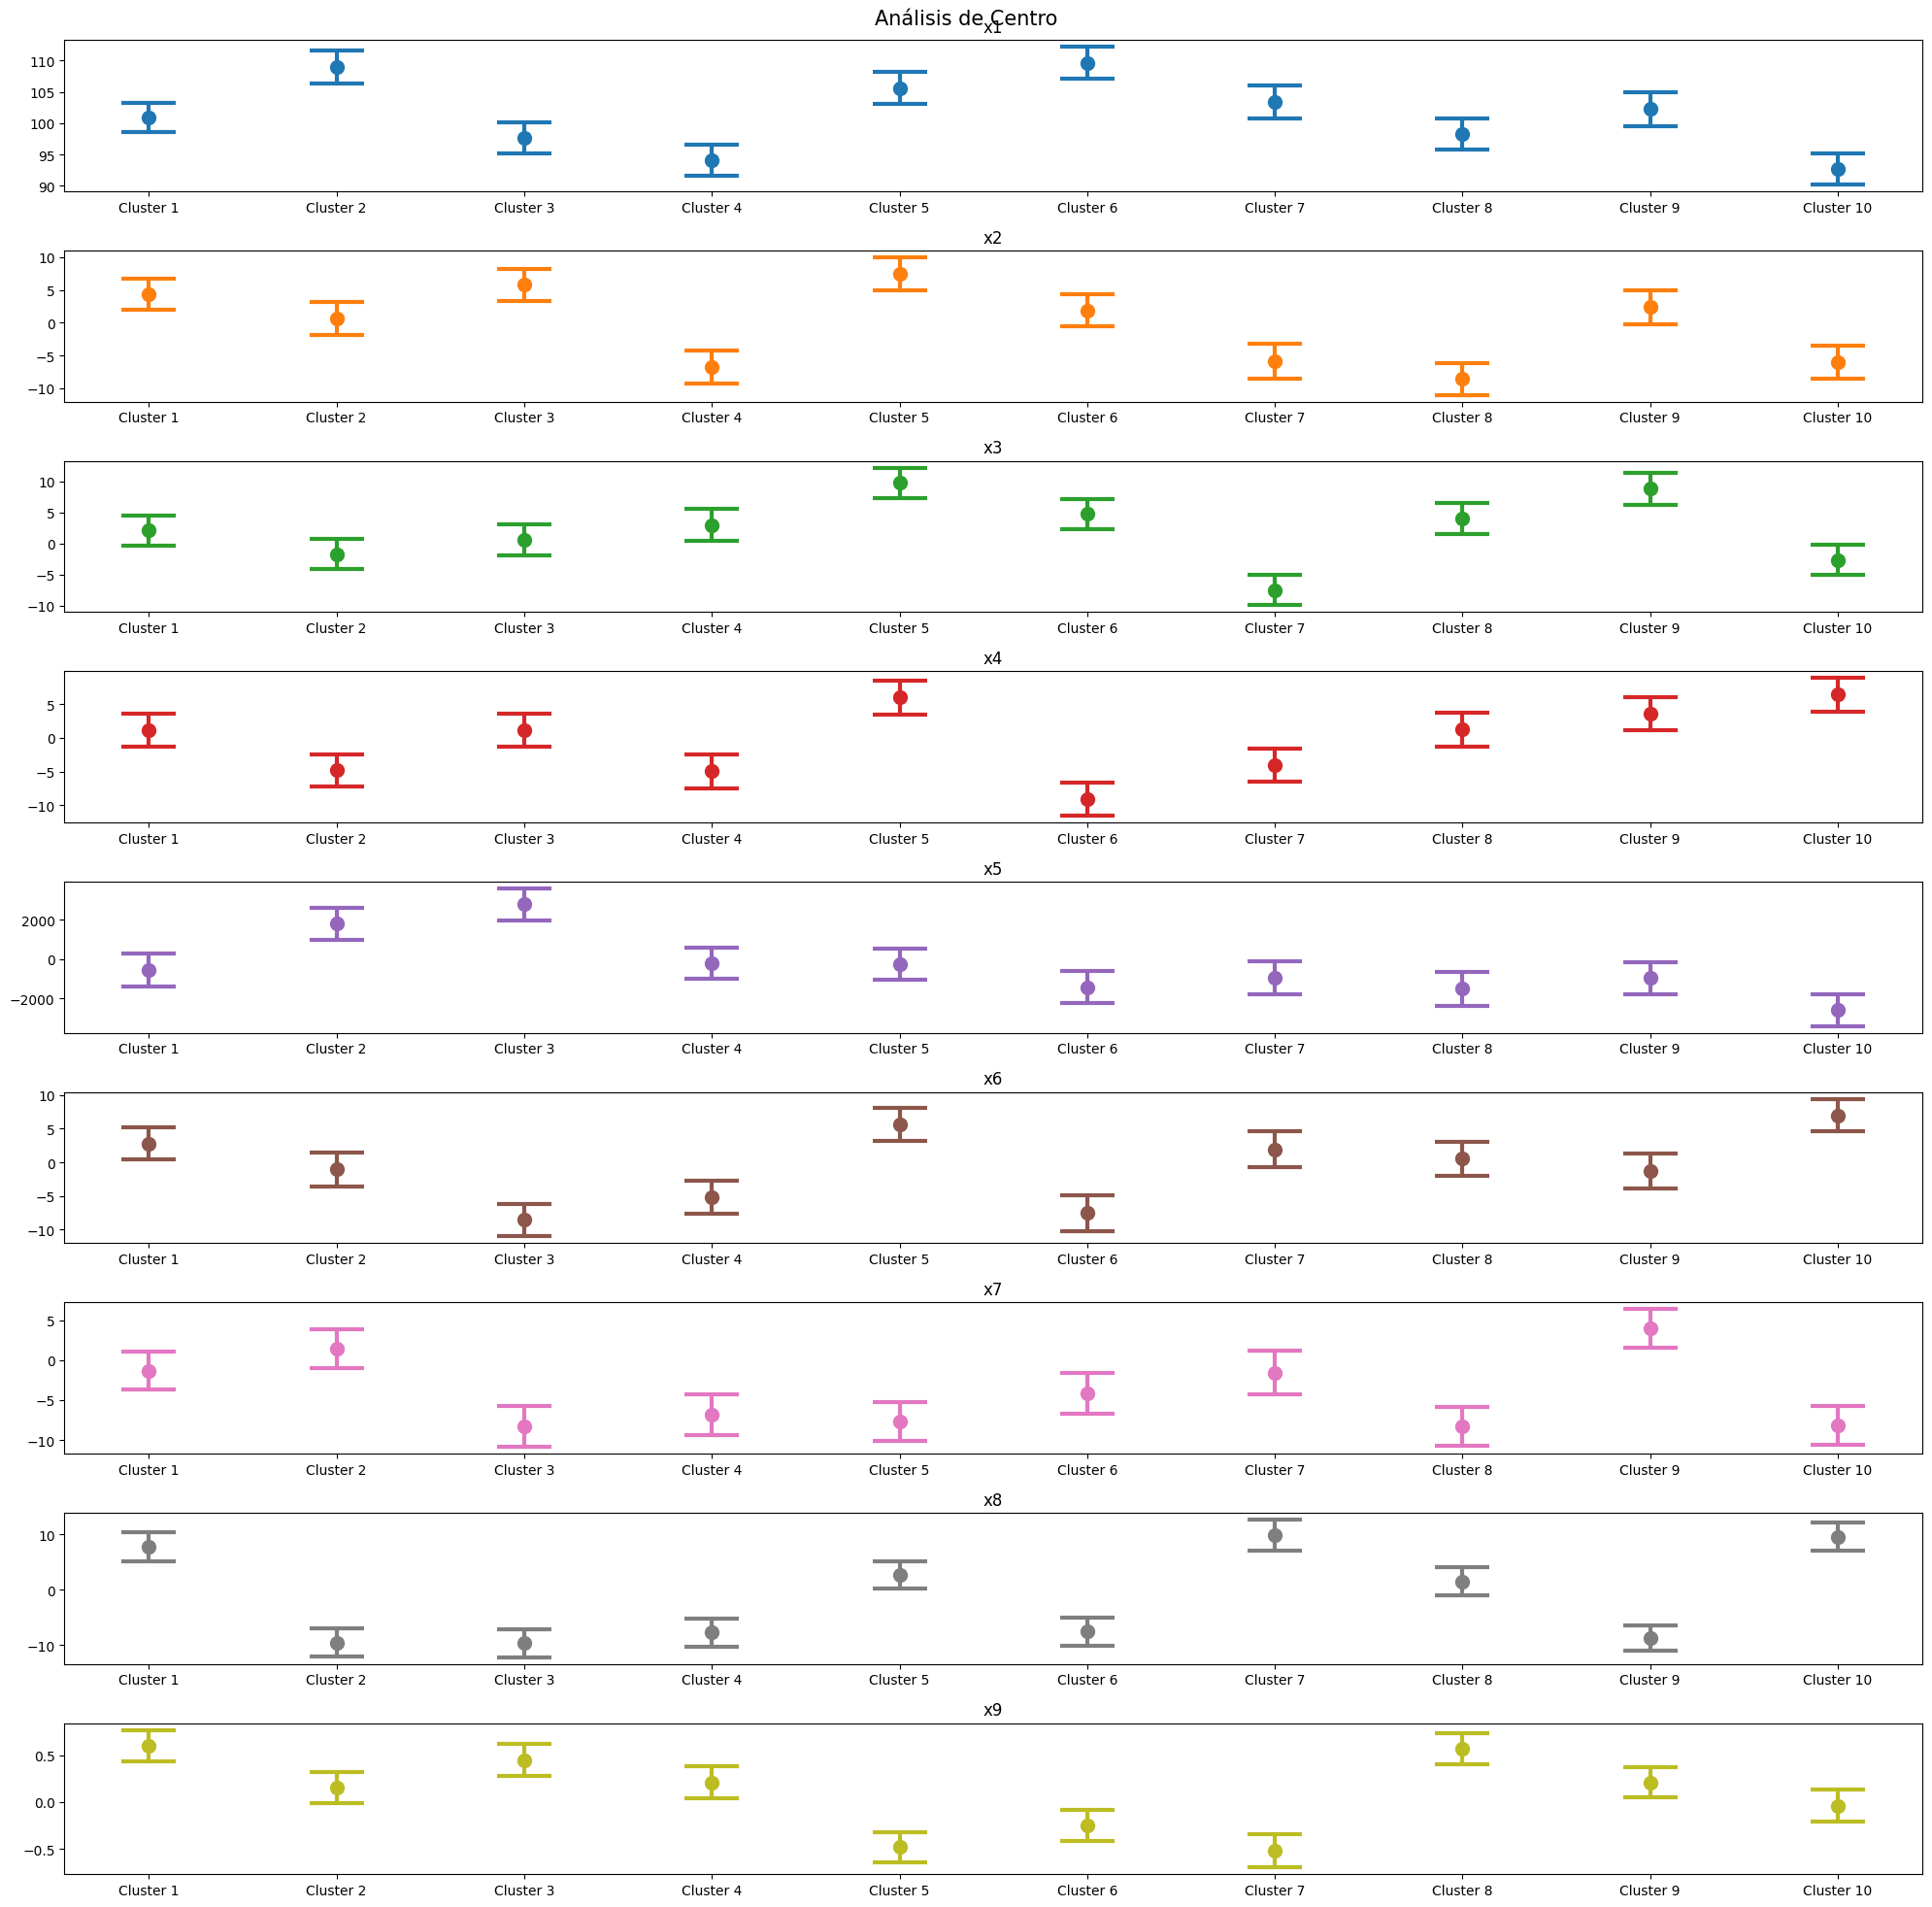

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def create_tables(df, labels, columns):
    df["labels"] = labels
    std = df.groupby("labels")[columns].std(numeric_only=True)
    mean = df.groupby("labels")[columns].mean(numeric_only=True)
    return mean, std


def center_analysis_viz(
    df, n_clusters, labels, columns, title="", figsize=(20, 20)
):
    clusters_axis = [f"Cluster {i}" for i in range(1, n_clusters + 1)]

    n_columns = len(columns)
    colors = list(mcolors.TABLEAU_COLORS.values())[:n_columns]
    fig, ax = plt.subplots(n_columns, figsize=figsize)

    mean_table, std_table = create_tables(df, labels, columns)

    for i in range(n_columns):
        ax[i].errorbar(
            clusters_axis,
            mean_table[columns[i]],
            yerr=std_table[columns[i]],
            capsize=20,
            linestyle="none",
            marker="o",
            lw=3,
            capthick=3,
            ms=10,
            c=colors[i],
        )
        ax[i].set_title(columns[i])
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()


center_analysis_viz(
    df,
    n_clusters=10,
    labels=labels_km,
    columns=num_vars,
    title="Análisis de Centro",
)

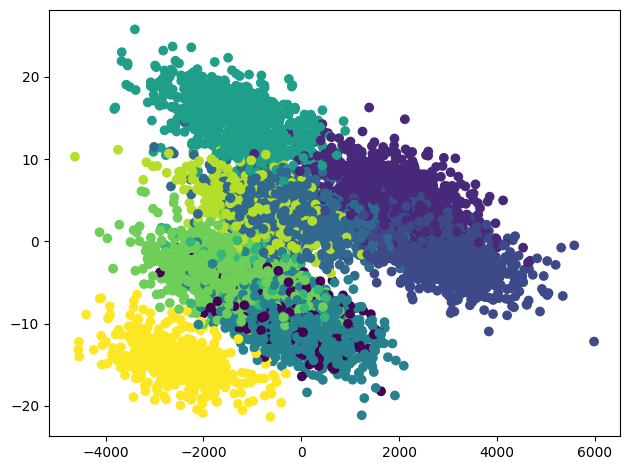

In [24]:
plt.scatter(pca_X["pca0"], pca_X["pca1"], c=labels_km)
plt.tight_layout()

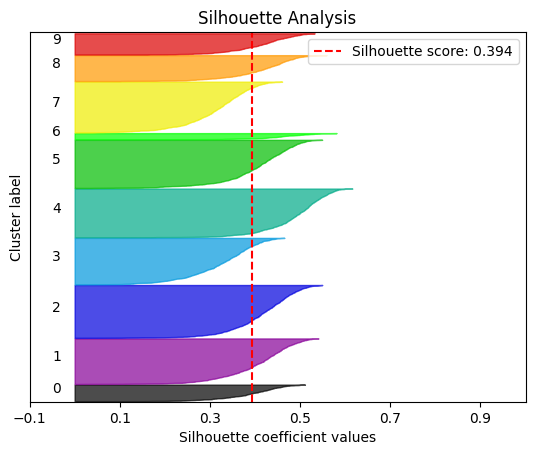

In [23]:
import scikitplot as skplt

skplt.metrics.plot_silhouette(X, labels_km)
plt.show()